In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [ ]:
# Set a seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)


In [ ]:
# Define a simple Convolutional Neural Network
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        return self.fc2(x)


In [ ]:
# Function for model training
def train_network(model, data_loader, loss_function, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in data_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()


In [ ]:
# Function to assess model performance
def assess_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            total_loss += loss_function(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    confusion_mtx = confusion_matrix(all_labels, all_preds)
    sensitivity = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)

    accuracy = correct_predictions / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)

    return avg_loss, accuracy, sensitivity


In [ ]:
# Function to assess model performance
def assess_model(model, data_loader):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            total_loss += loss_function(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    confusion_mtx = confusion_matrix(all_labels, all_preds)
    sensitivity = np.sum(np.diag(confusion_mtx)) / np.sum(confusion_mtx)

    accuracy = correct_predictions / len(data_loader.dataset)
    avg_loss = total_loss / len(data_loader)

    return avg_loss, accuracy, sensitivity


In [ ]:
# Prepare data transformations and download MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11555485.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 351098.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3214424.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7954291.76it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Define different batch sizes
batch_sizes = [32, 64, 128, 256, 512]

# Store results for plotting
train_losses, test_losses, train_accuracies, test_accuracies, sensitivities = [], [], [], [], []


In [ ]:
# Train and evaluate models for each batch size
for batch_size in batch_sizes:
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    cnn_model = SimpleCNN()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cnn_model.to(device)

    train_network(cnn_model, train_loader, loss_function, optimizer)

    # Evaluate on training data
    train_loss, train_accuracy, _ = assess_model(cnn_model, train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on testing data
    test_loss, test_accuracy, sensitivity = assess_model(cnn_model, test_loader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    sensitivities.append(sensitivity)


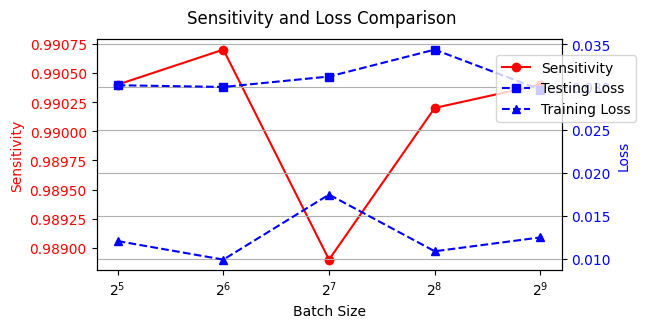

In [ ]:
# Plotting Sensitivity vs Loss
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Sensitivity', color='red')

# Adjusting the lengths for plotting
num_points = min(len(batch_sizes), len(sensitivities))
ax1.plot(batch_sizes[:num_points], sensitivities[:num_points], color='red', marker='o', label='Sensitivity')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='blue')

# Again, adjusting lengths for plotting
num_points_loss = min(len(batch_sizes), len(test_losses), len(train_losses))
ax2.plot(batch_sizes[:num_points_loss], test_losses[:num_points_loss], color='blue', linestyle='--', marker='s', label='Testing Loss')
ax2.plot(batch_sizes[:num_points_loss], train_losses[:num_points_loss], color='blue', linestyle='--', marker='^', label='Training Loss')
ax2.tick_params(axis='y', labelcolor='blue')

plt.xscale('log', base=2)
fig.suptitle('Sensitivity and Loss Comparison')
fig.legend(loc='upper left', bbox_to_anchor=(0.78, 0.85))
plt.grid()
plt.show()


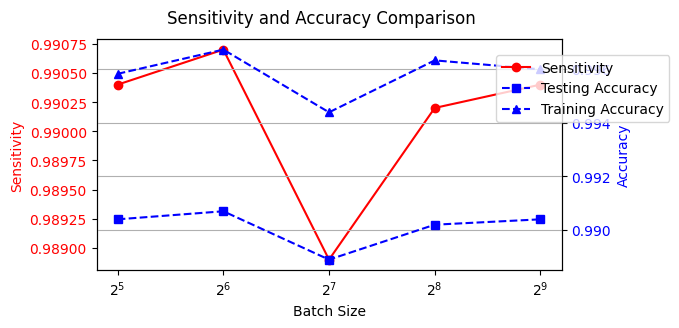

In [ ]:
# Plotting Sensitivity vs Accuracy
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Sensitivity', color='red')
# Adjusting the lengths for plotting
num_points = min(len(batch_sizes), len(sensitivities))
ax1.plot(batch_sizes[:num_points], sensitivities[:num_points], color='red', marker='o', label='Sensitivity')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='blue')

# Again, adjusting lengths for plotting
num_points_acc = min(len(batch_sizes), len(test_accuracies), len(train_accuracies))
ax2.plot(batch_sizes[:num_points_acc], test_accuracies[:num_points_acc], color='blue', linestyle='--', marker='s', label='Testing Accuracy')
ax2.plot(batch_sizes[:num_points_acc], train_accuracies[:num_points_acc], color='blue', linestyle='--', marker='^', label='Training Accuracy')
ax2.tick_params(axis='y', labelcolor='blue')

plt.xscale('log', base=2)
fig.suptitle('Sensitivity and Accuracy Comparison')
fig.legend(loc='upper left', bbox_to_anchor=(0.78, 0.85))
plt.grid()
plt.show()

